In [1]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

import re
import array

In [2]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

In [3]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a training array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [4]:
def generate_input_file_inelastic(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/12C_n_ine_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_ine_temp_input.in", "a")
    f.writelines(content)
    f.close()   

In [5]:
def frescox_output_inelastic(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file='frescox_outputs/test_temp.out'):

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    with open(output_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = [] 
    for idline, line in enumerate(content):
        if ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
        
    os.remove(input_file)
    os.remove(output_file)
    
    return sigma_omega_ratio

In [6]:
def frescox_run_inelastic(theta):
    theta_list = theta.tolist()
    f_l = []
    for para_obs in theta_list:
        para_obs += [3.5,1,0.3]
        generate_input_file_inelastic(para_obs)
        exp_output = frescox_output_inelastic()
        f_l.append(exp_output)

    return np.asarray(f_l).T

In [7]:
theta_tr = latin_sampling_3(100)
f_tr_1 = frescox_run_inelastic(theta_tr)
x_tr = np.array(range(362)).reshape((362, 1))

theta_test = latin_sampling_3(100)
f_test_1 = frescox_run_inelastic(theta_test)
x_test = np.array(range(181)).reshape((181, 1))

f_test = f_test_1
f_tr = f_tr_1

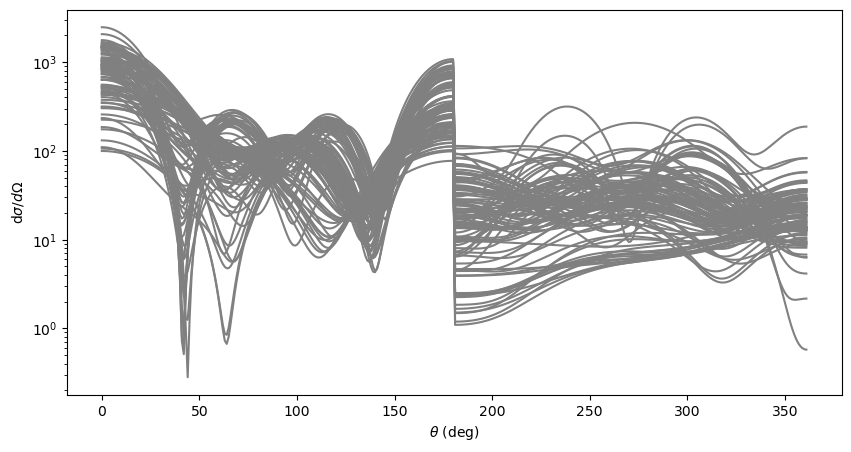

In [8]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(f_tr.shape[1]):
    ax.plot(x_tr, f_tr[:, i], color='grey', zorder=1)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'd$\sigma/d\Omega$')
ax.set_yscale('log')
pylab.show()

In [9]:
# def extract_partial_waves(file_extract='fort.17'):
#     '''
#     this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
#     corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
#     broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
#     '''
#     keys_array = []
    
#     # Initialize a dictionary to store the values
#     data_dict = {}

#     # Initialize a counter for lines starting with "401"
#     count_401 = 0

#     # Specify the file path
#     file_path = 'fort.17'

#     # Regular expression pattern to match lines with the desired format
#     pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')

#     # Open the file and read its contents
#     with open(file_path, 'r') as file:
#         lines = file.readlines()

#     # Initialize a variable to hold the current key
#     current_key = None

#     # Iterate through the lines to find lines that match the pattern
#     for i in range(len(lines)):
#         line = lines[i].strip()
#         match = pattern.match(line)
#         if match:
#             # Convert the first 6 values of the line to floats and use them as part of the key
#             key_values = match.group(1).split()[:6]
#             key_values = [float(value) for value in key_values]
#             current_key = tuple([count_401] + key_values)
#             # Initialize an empty list for the values associated with the key
#             data_dict[current_key] = []
#             i += 1  # Move to the next line to start reading values
#             while i < len(lines) and not lines[i].startswith("201"):
#                 # Split the current line into values
#                 values = lines[i].split()
#                 # Convert values to floats and append them to the current key's list
#                 data_dict[current_key].extend([float(value) for value in values])
#                 i += 1
#         elif line.startswith("201"):
#             # Increment the counter for lines starting with "401"
#             count_401 += 1
    
#     keys_array = list(data_dict.keys())
  
    
#     return data_dict, keys_array

In [10]:
# def extract_partial_waves(file_extract='fort.17'):
#     '''
#     this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
#     corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
#     broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
#     '''
#     keys_array = []
    
#     # Initialize a dictionary to store the values
#     data_dict = {}

#     # Initialize a counter for lines starting with "401"
#     count_401 = 0

#     # Specify the file path
#     file_path = 'fort.17'

#     # Regular expression pattern to match lines with the desired format
#     pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')


#     # Open the file and read its contents
#     with open(file_path, 'r') as file:
#         lines = file.readlines()

#     # Initialize a variable to hold the current key
#     current_key = None

#     # Iterate through the lines to find lines that match the pattern
#     for i in range(len(lines)):
#         line = lines[i].strip()
#         match = pattern.match(line)
#         if match:
#             # Convert the first 6 values of the line to floats and use them as part of the key
#             key_values = match.group(1).split()[:6]
#             key_values = [float(value) for value in key_values]
#             current_key = tuple([count_401] + key_values)
#             # Initialize an empty list for the values associated with the key
#             data_dict[current_key] = []
#             i += 1  # Move to the next line to start reading values
#             while i < len(lines)  and not lines[i].startswith("201"):
#                 # Split the current line into values
#                 line2 = lines[i].strip()
#                 match2 = pattern.match(line2)
#                 if match2:
#                     break
#                 else:
#                     values = lines[i].split()
#                     # Convert values to floats and append them to the current key's list
#                     data_dict[current_key].extend([float(value) for value in values])
#                     i += 1
#         elif line.startswith("201"):
#             # Increment the counter for lines starting with "401"
#             count_401 += 1
    
#     keys_array = list(data_dict.keys())
  
    
#     return data_dict, keys_array

In [11]:
def extract_partial_waves(file_extract='fort.17'):
    '''
    this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    keys_array = []
    
    # Initialize a dictionary to store the values
    data_dict = {}

    # Initialize a counter for lines starting with "401"
    count_401 = 0

    # Specify the file path
    file_path = 'fort.17'

    # Regular expression pattern to match lines with the desired format
    pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')
    
    pattern2 = re.compile(r'^\s*201\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+-1\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+')

    pattern3 = re.compile(r'^\s*-1\s+0\s+0\.0\s+0\.0\s+0\s+0\.0\s+0\.0{10}\s+0\.0{10}\s+0\.0{8}')

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize a variable to hold the current key
    current_key = None

    # Iterate through the lines to find lines that match the pattern
    for i in range(len(lines)):
        line = lines[i].strip()
        match = pattern.match(line)
        if match:
            # Convert the first 6 values of the line to floats and use them as part of the key
            key_values = match.group(1).split()[:6]
            key_values = [float(value) for value in key_values]
            current_key = tuple([count_401] + key_values)
            # Initialize an empty list for the values associated with the key
            data_dict[current_key] = []
            i += 1  # Move to the next line to start reading values
            while i < len(lines)  and not lines[i].startswith("1001"):
                # Split the current line into values
                line2 = lines[i].strip()
                match2 = pattern.match(line2)
                line4 = lines[i].strip()
                match4 = pattern3.match(line2)
                if match2:
                    break
                if match4:
                      i+=1
                else:
                    values = lines[i].split()
                    # Convert values to floats and append them to the current key's list
                    data_dict[current_key].extend([float(value) for value in values])
                    i += 1
        elif lines[i].startswith("1001"):
            # Increment the counter for lines starting with "401"
            count_401 += 1
    
    keys_array = list(data_dict.keys())
  
    
    return data_dict, keys_array

In [12]:
#extract partial waves and see the length of each extracted partial wave
#then print out th keys array
a,b = extract_partial_waves()
# print(a.get(b[1]))
# print(a.get(b[5]))

for i in range(21):
    print(len(a.get(b[i])))
    
print(b)

2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
2002
[(1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0), (2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (2, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0), (2, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0), (3, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0), (3, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0), (3, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0), (3, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0), (4, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0), (4, 2.0, 1.0, 1.0, 3.0, 3.0, 3.0), (4, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0), (4, 2.0, 5.0, 5.0, 3.0, 3.0, 3.0), (5, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0), (5, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0), (5, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0), (5, 2.0, 6.0, 6.0, 4.0, 4.0, 4.0), (6, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0), (6, 2.0, 3.0, 3.0, 5.0, 5.0, 5.0), (6, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0), (6, 2.0, 7.0, 7.0, 5.0, 5.0, 5.0)]


In [13]:
def wave_functions_format_imaginary(file_extract='fort.17'):
    '''
    This function takes as input the fort.17 file and using the keys from the function extract_partial_waves
    then writes the wavefunction from the fresco output to \psi= real + imag
    '''
    waves_exact = {}
    
    data_dict, keys_array = extract_partial_waves()
    
    for key in keys_array:
        temp_real_array = []
        temp_imag_array = []
        temp_wave = data_dict.get(key)
        for i in range(len(np.array(temp_wave))):
            radial = temp_wave[i]
            if (i % 2 != 0):
                temp_imag_array.append(radial)
            if (i % 2 == 0) :
                temp_real_array.append(radial)
                
        waves_exact[key] = np.array(temp_real_array) + 1j* np.array(temp_imag_array)
        
        
    return waves_exact, keys_array

In [14]:
# run the function above that extracts the partial waves and puts them in the real + imag format. 
a,b = wave_functions_format_imaginary()

In [15]:
def frescox_output_inelastic_wavefunctions(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file='fort.17'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary(output_file)
    
        
    os.remove(input_file)
    os.remove(output_file)
    
    return waves, keys

In [16]:
def frescox_run_inelastic_waves(theta):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    theta_list = theta.tolist()
    waves_array = []
#    keys_array = []
    for para_obs in theta_list:
        #para_obs += [3.5,1,0.3]
        generate_input_file_inelastic(para_obs)
        waves_per_calc, keys_per_calc  = frescox_output_inelastic_wavefunctions()
        waves_array.append(waves_per_calc)
#        keys_array.append(keys_per_calc)

    return waves_array, keys_per_calc

In [38]:
theta_tr = latin_sampling_3(100)
a,b = frescox_run_inelastic_waves(theta_tr)

In [40]:
#do the SVD decomposition of the wave functions using the dictionary keys.
nbasis = 20
SVD_per_wave = []
for j in range(1):
    wave_set = []
    for i in range(len(a)):
        wave_keyed = a[i].get(b[j])
        wave_set.append(wave_keyed)
    np_wave_set = np.array(wave_set).T
    U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
    print(S)
    basis = U[:, :nbasis]
    SVD_per_wave.append(basis)
    

[1.81580857e+02 1.05887329e+02 1.15329845e+01 8.31453163e+00
 3.13234096e+00 8.27952395e-01 2.23291613e-01 9.94386539e-02
 3.42813969e-02 1.07489257e-02 4.01901895e-03 1.48878989e-03
 4.98585959e-04 3.65741112e-04 1.69803133e-04 1.55464335e-04
 1.50265225e-04 1.47963530e-04 1.46611974e-04 1.45810495e-04
 1.45076773e-04 1.44089044e-04 1.42728154e-04 1.41793532e-04
 1.40651125e-04 1.40240961e-04 1.37793152e-04 1.37111716e-04
 1.35694681e-04 1.35048738e-04 1.34382273e-04 1.33390699e-04
 1.32918735e-04 1.32007903e-04 1.31273929e-04 1.30634444e-04
 1.30075180e-04 1.29394558e-04 1.28470018e-04 1.27581038e-04
 1.27145227e-04 1.26439758e-04 1.25378309e-04 1.24648971e-04
 1.23998264e-04 1.23144719e-04 1.22923624e-04 1.22003882e-04
 1.20975182e-04 1.20406277e-04 1.19169838e-04 1.18992343e-04
 1.18787712e-04 1.17758488e-04 1.17205583e-04 1.16501724e-04
 1.15978965e-04 1.15564648e-04 1.14668345e-04 1.14159965e-04
 1.13528518e-04 1.12681283e-04 1.12056435e-04 1.11280995e-04
 1.10726107e-04 1.099575

In [28]:
print(len(a))

10


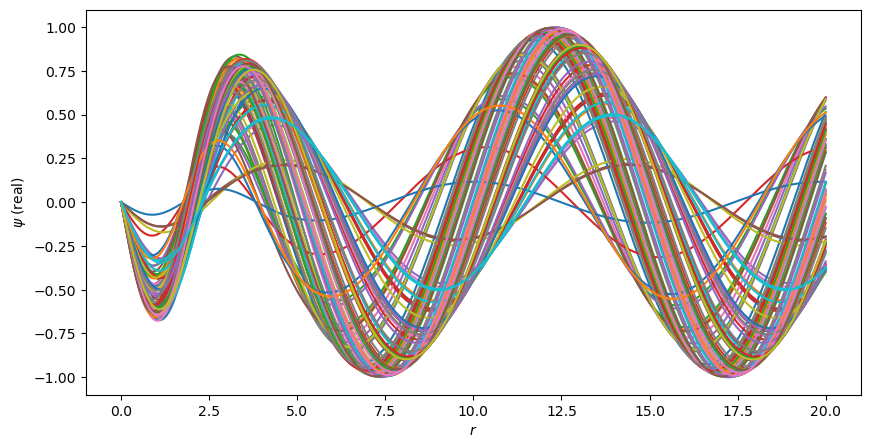

(1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)


In [34]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_set = []
for i in range(len(a)):
    wave_keyed = a[i].get(b[0])
    wave_set.append(wave_keyed)
#print(np.shape(wave_set))

r = np.linspace(0,20,1001)

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(len(a)):
    ax.plot(r, np.real(wave_set[i]), zorder=1)
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#ax.set_yscale('log')
pylab.show()
print(b[0])

In [33]:
def SVD_extract_frescox(theta,nbasis):
    '''
    this function takes as an input the array of paramters to solve, and extracts the wavefunctions from fresco
    as a dictionary, then uses the dictionary keys to appropriately obtain the SVD components for each dictionary.
    The output is an array with the SVD basis components, in the same order of partial waves as the keys.
    '''
    waves, keys = frescox_run_inelastic_waves(theta)
    SVD_per_wave = []
    for j in range(len(keys)):
        wave_set = []
        for i in range(len(waves)):
            wave_keyed = waves[i].get(keys[j])
            wave_set.append(wave_keyed)
        np_wave_set = np.array(wave_set).T
        U, S, Vt = np.linalg.svd(np_wave_set, full_matrices=False)
        basis = U[:, :nbasis]
        SVD_per_wave.append(basis)
        
    return SVD_per_wave, keys

In [34]:
#extract the partial waves SVD components
a,b = SVD_extract_frescox(theta_tr,10)

In [35]:
#lets look at the keys
print(b)

[(1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0), (2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (2, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0), (2, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0), (3, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0), (3, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0), (3, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0), (3, 2.0, 4.0, 4.0, 2.0, 2.0, 2.0), (4, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0), (4, 2.0, 1.0, 1.0, 3.0, 3.0, 3.0), (4, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0), (4, 2.0, 5.0, 5.0, 3.0, 3.0, 3.0), (5, 1.0, 4.0, 4.0, 4.0, 4.0, 4.0), (5, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0), (5, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0), (5, 2.0, 6.0, 6.0, 4.0, 4.0, 4.0), (6, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0), (6, 2.0, 3.0, 3.0, 5.0, 5.0, 5.0), (6, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0), (6, 2.0, 7.0, 7.0, 5.0, 5.0, 5.0)]


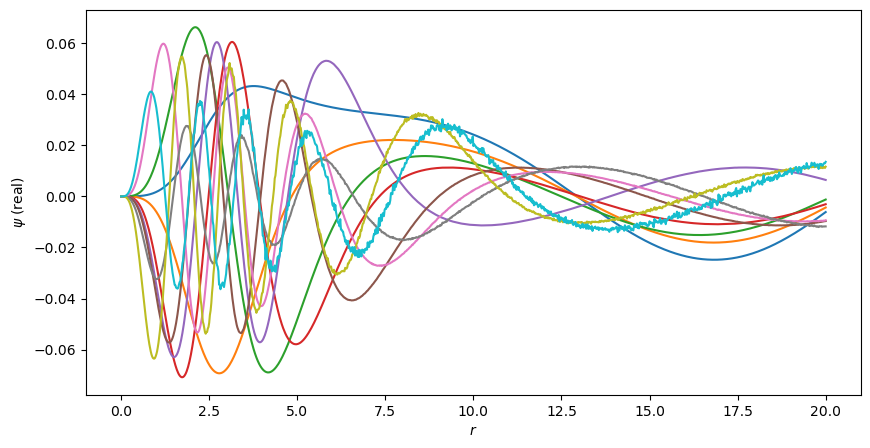

In [36]:
#plot the partial waves SVD, see the fuzzy behavior seen.
r = np.linspace(0,20,1001)

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(10):
    ax.plot(r, np.real(a[4]).T[i], zorder=1)
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$ (real)')
#ax.set_yscale('log')
pylab.show()